In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from medmnist import PathMNIST

/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <2A8DB508-8AAF-3FF1-BDFE-9EF17CC2B482> /opt/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("using cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("using mps")
else:
    print("none")

using mps


In [10]:
# Download and load PathMNIST dataset
data_flag = 'pathmnist'
download = True

# transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Load datasets with transforms
train_dataset = PathMNIST(split='train', transform=train_transform, download=True)
val_dataset = PathMNIST(split='val', transform=test_transform, download=True)
test_dataset = PathMNIST(split='test', transform=test_transform, download=True)

# data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(np.unique(train_dataset.labels))}")

Using downloaded and verified file: /Users/bz/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/bz/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/bz/.medmnist/pathmnist.npz
Training samples: 89996
Validation samples: 10004
Test samples: 7180
Number of classes: 9


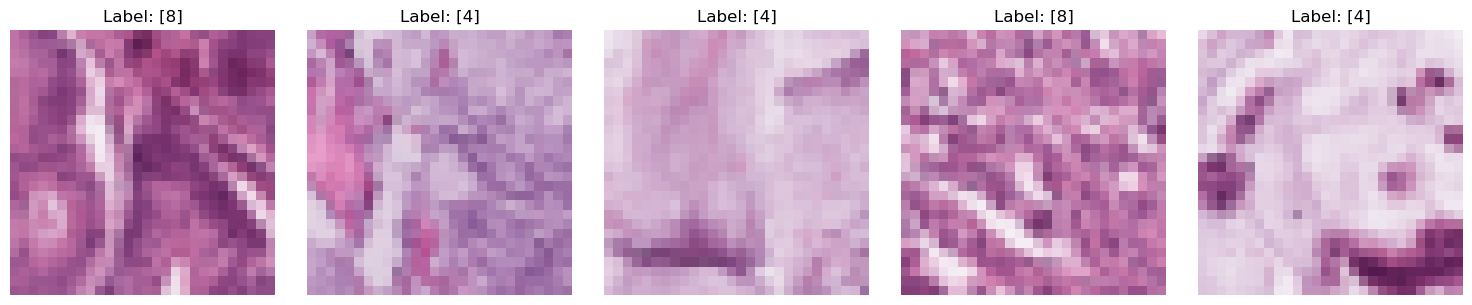

In [11]:
import matplotlib.pyplot as plt
import torchvision
import os

save_dir = 'example_images'
os.makedirs(save_dir, exist_ok=True)

# Visualize a few samples
num_samples = 5 
figure = plt.figure(figsize=(15, 3))

for i in range(num_samples):
    image, label = test_dataset[i]
    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image * std + mean
    
    image = torchvision.transforms.ToPILImage()(image)
    
    image.save(os.path.join(save_dir, f'sample_{i}_label_{label}.png'))
    
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Using downloaded and verified file: /Users/bz/.medmnist/pathmnist.npz
img shape: (28, 28, 3)
img shape: (28, 28, 3)
img shape: (28, 28, 3)
img shape: (28, 28, 3)


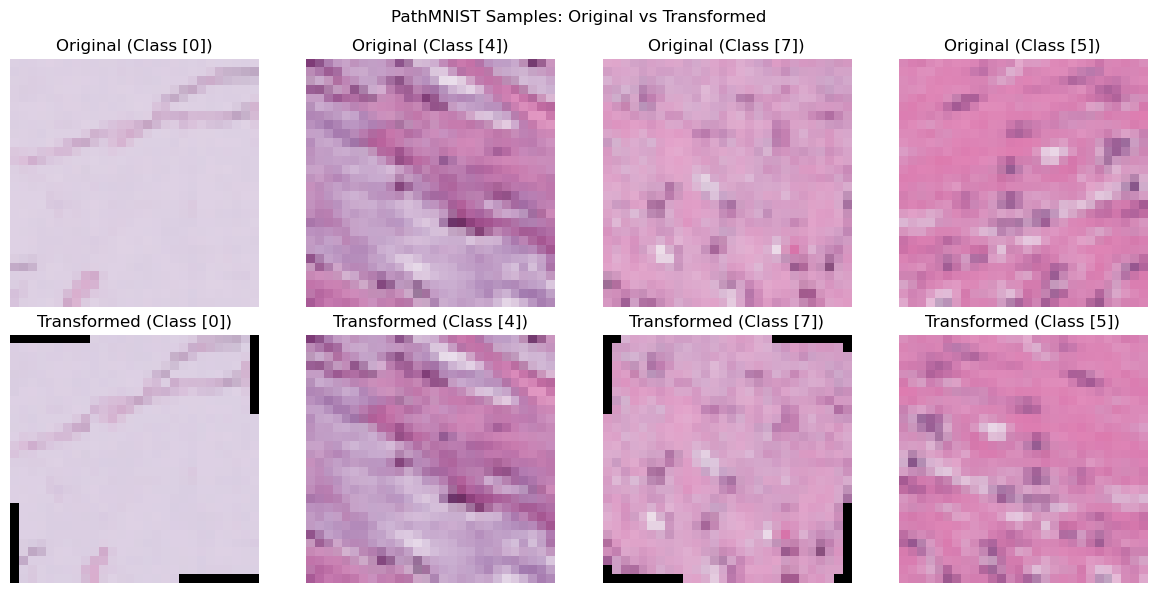

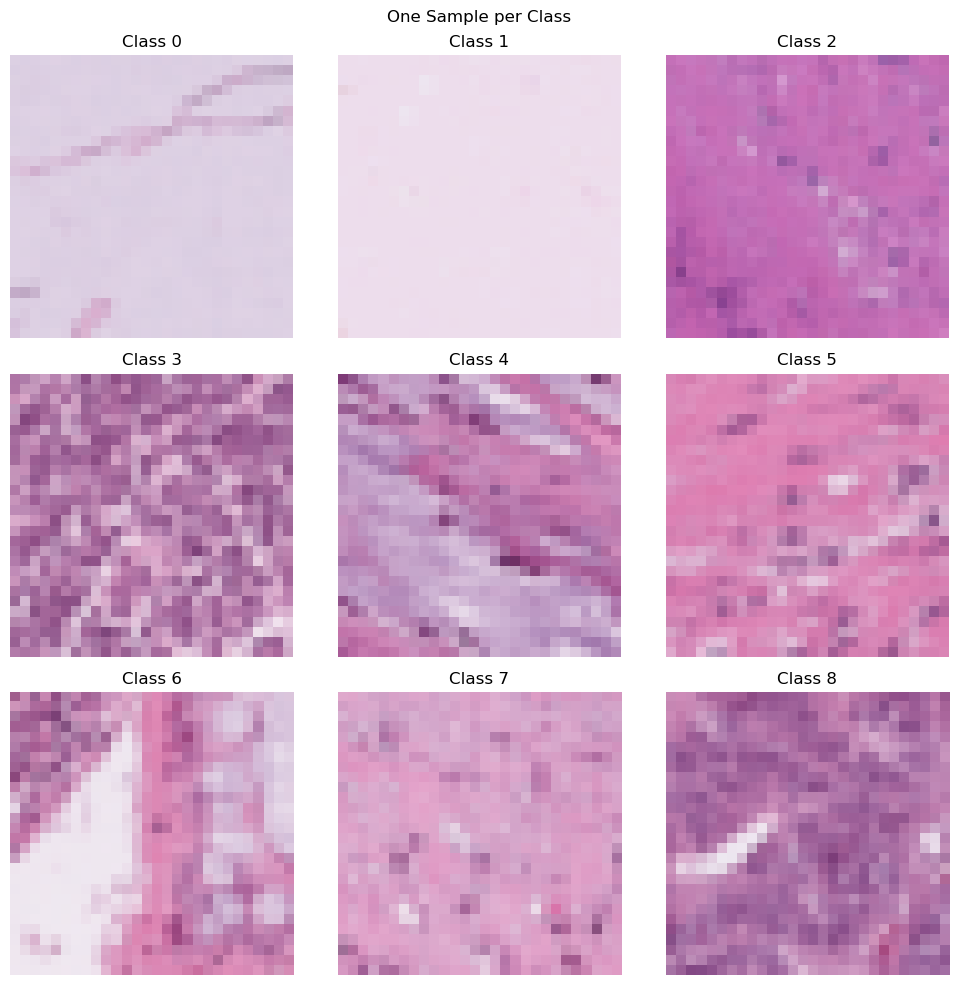

In [12]:
# Load untransformed dataset for visualization and comparison
dataset_original = PathMNIST(split='train', download=True)

# Original vs transformed
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
plt.suptitle('PathMNIST Samples: Original vs Transformed')

for i in range(4):
    img_orig, label_orig = dataset_original[i]
    img_trans, label_trans = train_dataset[i]
    
    # Plot original
    axes[0,i].imshow(img_orig)
    axes[0,i].set_title(f'Original (Class {label_orig})')
    axes[0,i].axis('off')
    
    # Plot transformed, unnormalize the transformed image
    img_trans = img_trans.numpy().transpose((1, 2, 0))
    img_trans = img_trans * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_trans = np.clip(img_trans, 0, 1)
    # print("img shape:", np.array(img_trans).shape)

    
    axes[1,i].imshow(img_trans)
    axes[1,i].set_title(f'Transformed (Class {label_trans})')
    axes[1,i].axis('off')

plt.tight_layout()
plt.show()

# One sample from each class
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
plt.suptitle('One Sample per Class')

for class_idx in range(9):
    for idx in range(len(dataset_original)):
        img, label = dataset_original[idx]
        if label == class_idx:
            ax = axes[class_idx//3, class_idx%3]
            ax.imshow(img)
            ax.set_title(f'Class {class_idx}')
            ax.axis('off')
            break

plt.tight_layout()
plt.show()

In [13]:
class PathMNISTCNN(nn.Module):
    def __init__(self):
        super(PathMNISTCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 28x28x3 -> 28x28x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 28x28x32 -> 14x14x32
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 14x14x32 -> 14x14x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 14x14x64 -> 7x7x64
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 7x7x64 -> 7x7x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 7x7x128 -> 3x3x128
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),  # 3x3x128 -> 1152
            nn.Linear(3 * 3 * 128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 9)  # 9 classes output
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

# model instance
model = PathMNISTCNN()
print(model)

PathMNISTCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=256

In [6]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.squeeze()).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device, print_interval=100):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the param gradients
        optimizer.zero_grad()
        
        # Fwd prop
        outputs = model(inputs)

        # Backprop
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        # Update
        optimizer.step()
        
        # Stats
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels.squeeze()).sum().item()
        
        # Print every print_interval mini-batches
        if (batch_idx + 1) % print_interval == 0:
            current_loss = running_loss / (batch_idx + 1)
            current_acc = 100. * correct / total
            print(f'  Batch [{batch_idx + 1}/{len(train_loader)}] | Loss: {current_loss:.4f} | Acc: {current_acc:.2f}%')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [8]:
# Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)
num_epochs = 3

print(f"Training on {device}")
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    
    # train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, print_interval=100)
    
    # validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    
    # Print epoch summary
    print('Epoch Summary:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)

print("Finished training")

Training on mps

Epoch [1/3]
  Batch [100/2813] | Loss: 1.4374 | Acc: 46.38%
  Batch [200/2813] | Loss: 1.2511 | Acc: 52.38%
  Batch [300/2813] | Loss: 1.1562 | Acc: 56.42%
  Batch [400/2813] | Loss: 1.0817 | Acc: 59.19%
  Batch [500/2813] | Loss: 1.0279 | Acc: 61.31%
  Batch [600/2813] | Loss: 0.9907 | Acc: 62.75%
  Batch [700/2813] | Loss: 0.9569 | Acc: 64.25%
  Batch [800/2813] | Loss: 0.9277 | Acc: 65.46%
  Batch [900/2813] | Loss: 0.9014 | Acc: 66.48%
  Batch [1000/2813] | Loss: 0.8772 | Acc: 67.49%
  Batch [1100/2813] | Loss: 0.8589 | Acc: 68.30%
  Batch [1200/2813] | Loss: 0.8435 | Acc: 68.93%
  Batch [1300/2813] | Loss: 0.8263 | Acc: 69.54%
  Batch [1400/2813] | Loss: 0.8124 | Acc: 70.10%
  Batch [1500/2813] | Loss: 0.7939 | Acc: 70.79%
  Batch [1600/2813] | Loss: 0.7806 | Acc: 71.31%
  Batch [1700/2813] | Loss: 0.7687 | Acc: 71.78%
  Batch [1800/2813] | Loss: 0.7599 | Acc: 72.15%
  Batch [1900/2813] | Loss: 0.7487 | Acc: 72.55%
  Batch [2000/2813] | Loss: 0.7388 | Acc: 72.96%


In [1]:
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    # For storing all predictions and true labels
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # print(inputs.shape)
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.squeeze()).sum().item()
            
            # Store predictions and labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.squeeze().cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.2f}%')
    return test_loss, test_acc, all_predictions, all_labels

# use best model
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)
# run evaluation
test_loss, test_acc, predictions, true_labels = test(model, test_loader, criterion, device)

NameError: name 'model' is not defined

In [3]:
print(torch.__version__)

2.3.0


In [18]:
checkpoint = torch.load('best_model.pth')
print(type(checkpoint)) 

<class 'collections.OrderedDict'>
